<a href="https://colab.research.google.com/github/w95wayne10/computer_vision/blob/master/summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
def Dilation(img, pattern):
  n,m = pattern.shape
  padding_img = np.zeros((img.shape[0]+n-1,img.shape[1]+m-1))
  n_size = (n-1)//2
  m_size = (m-1)//2
  padding_img[n_size:-n_size,m_size:-m_size]=img
  padding_img_to1 = padding_img
  convolu_img_to1 = np.zeros(img.shape)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      convolu_img_to1[i,j] = np.max(padding_img_to1[i:i+n,j:j+m][pattern])
  return convolu_img_to1

def Erosion(img, pattern):
  n,m = pattern.shape
  padding_img = np.zeros((img.shape[0]+n-1,img.shape[1]+m-1))
  n_size = (n-1)//2
  m_size = (m-1)//2
  padding_img[n_size:-n_size,m_size:-m_size]=img
  padding_img_to1 = padding_img
  convolu_img_to1 = np.zeros(img.shape)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      convolu_img_to1[i,j] = np.min(padding_img_to1[i:i+n,j:j+m][pattern])
  return convolu_img_to1

In [ ]:
# 讀檔
lena_gray = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)

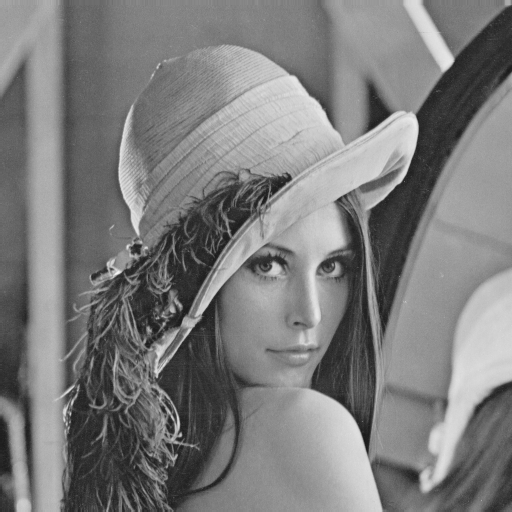

In [ ]:
cv2_imshow(lena_gray)

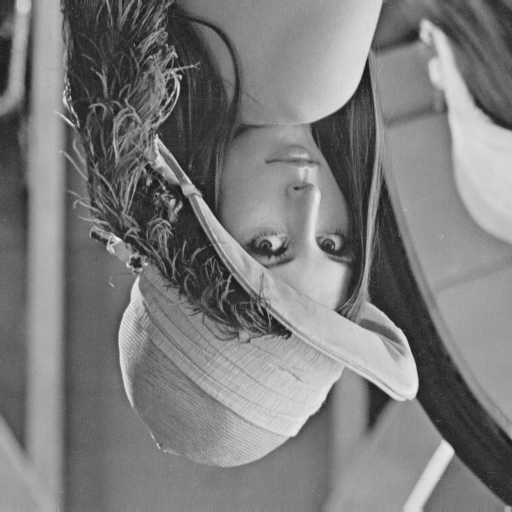

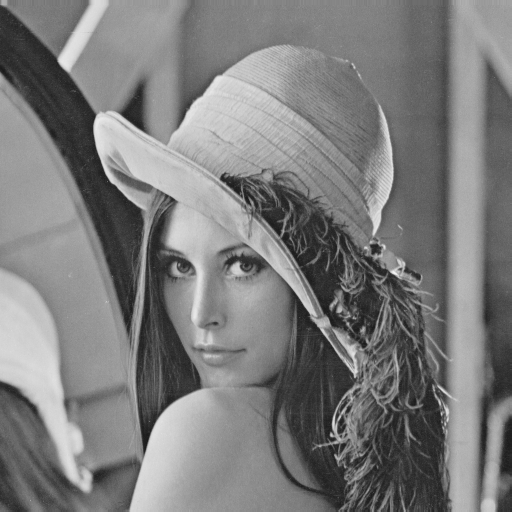

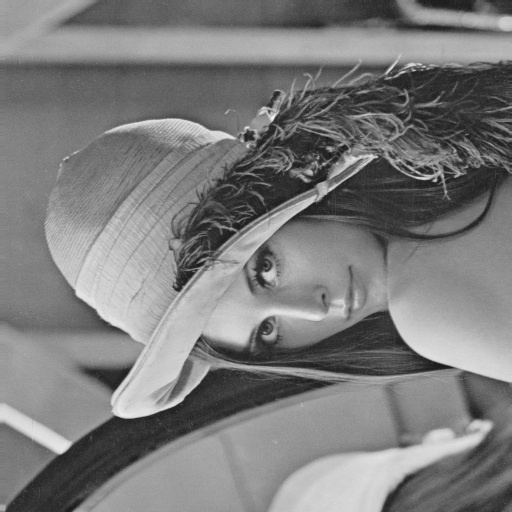

In [ ]:
# 變更順序達到旋轉鏡射等效果
upside_down_lena = lena_gray[::-1, :]
rightside_left_lena = lena_gray[:, ::-1]
diagonally_flip_lena = lena_gray.T

cv2_imshow(upside_down_lena)
cv2_imshow(rightside_left_lena)
cv2_imshow(diagonally_flip_lena)
#cv2.imwrite('upside_down_lena.bmp', upside_down_lena)
#cv2.imwrite('rightside_left_lena.bmp', rightside_left_lena)
#cv2.imwrite('diagonally_flip_lena.bmp', diagonally_flip_lena)

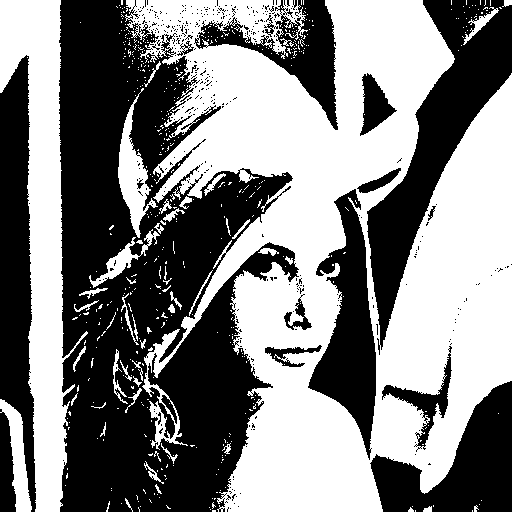

In [ ]:
# 二元化
binarize_lena = lena_gray//128*255
cv2_imshow(binarize_lena)
#cv2.imwrite('binarize_lena.bmp', binarize_lena)

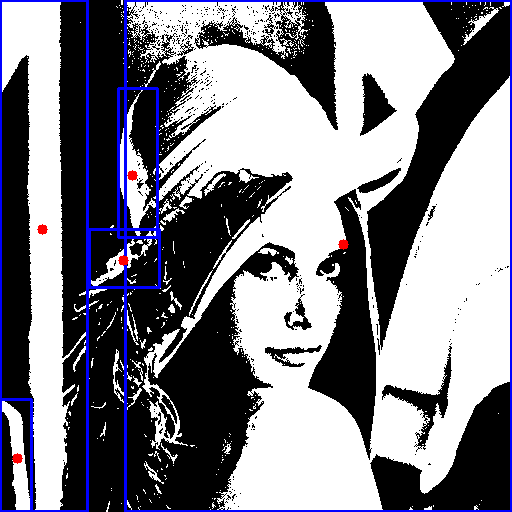

In [ ]:
# 分群
# 1. 分析
IDlist = []
IDlist.append(0)
IDtable = np.zeros((512,512),dtype=int)
ID = 1
for r, row in enumerate(binarize_lena):
  for c, pix in enumerate(row):
    if pix==0:
      continue
    if r:
      if c and IDtable[r-1,c-1]:
        IDtable[r,c] = IDtable[r-1,c-1]
      elif IDtable[r-1,c]:
        if IDtable[r,c]:
          IDlist[IDtable[r-1,c]]["neighbor"].add(IDtable[r,c])
          IDlist[IDtable[r,c]]["neighbor"].add(IDtable[r-1,c])
        else:
          IDtable[r,c] = IDtable[r-1,c]
      elif c<511 and IDtable[r-1,c+1]:
        if IDtable[r,c]:
          IDlist[IDtable[r-1,c+1]]["neighbor"].add(IDtable[r,c])
          IDlist[IDtable[r,c]]["neighbor"].add(IDtable[r-1,c+1])
        else:
          IDtable[r,c] = IDtable[r-1,c+1]
    if c and IDtable[r,c-1]:
      if IDtable[r,c]:
        IDlist[IDtable[r,c-1]]["neighbor"].add(IDtable[r,c])
        IDlist[IDtable[r,c]]["neighbor"].add(IDtable[r,c-1])
      else:
        IDtable[r,c] = IDtable[r,c-1]
    if not IDtable[r,c]:
      IDtable[r,c] = ID
      ID+=1
      IDlist.append({"up":512,"down":0,"left":512,"right":0,"count":0,"sum":[0,0],"neighbor":set()})
    IDlist[IDtable[r,c]]["up"] = min(IDlist[IDtable[r,c]]["up"],r)
    IDlist[IDtable[r,c]]["down"] = max(IDlist[IDtable[r,c]]["down"],r)
    IDlist[IDtable[r,c]]["left"] = min(IDlist[IDtable[r,c]]["left"],c)
    IDlist[IDtable[r,c]]["right"] = max(IDlist[IDtable[r,c]]["right"],c)
    IDlist[IDtable[r,c]]["count"] += 1
    IDlist[IDtable[r,c]]["sum"][0] += r
    IDlist[IDtable[r,c]]["sum"][1] += c
for i in range(len(IDlist)-1,1,-1):
  if not IDlist[i]['neighbor']:
    continue
  belong = min(IDlist[i]['neighbor'])
  if belong == i:
    continue
  for j in IDlist[i]['neighbor']:
    if i==j:
      continue
    IDlist[j]['neighbor'].add(belong)
    if i in IDlist[j]['neighbor']:
      IDlist[j]['neighbor'].remove(i)
  IDlist[belong]["up"] = min(IDlist[belong]["up"],IDlist[i]["up"])
  IDlist[belong]["down"] = max(IDlist[belong]["down"],IDlist[i]["down"])
  IDlist[belong]["left"] = min(IDlist[belong]["left"],IDlist[i]["left"])
  IDlist[belong]["right"] = max(IDlist[belong]["right"],IDlist[i]["right"])
  IDlist[belong]["count"] += IDlist[i]["count"]
  IDlist[belong]["sum"][0] += IDlist[i]["sum"][0]
  IDlist[belong]["sum"][1] += IDlist[i]["sum"][1]
  IDlist.pop(i)
for i in range(len(IDlist)-1,1,-1):
  if IDlist[i]["count"]<500:
    IDlist.pop(i)
# 2. 圖上標記
image = cv2.cvtColor(binarize_lena, cv2.COLOR_GRAY2BGR)
for grp in IDlist:
  if grp == 0:
    continue
  image = cv2.circle(image, 
          (int(np.round(grp["sum"][1]/grp["count"])), int(np.round(grp["sum"][0]/grp["count"]))), 
          radius=0, 
          color=(0, 0, 255), 
          thickness=10)
  image = cv2.rectangle(image, (grp["left"],grp["up"]), (grp["right"],grp["down"]), (255,0, 0), 2)
cv2_imshow(image)
# cv2.imwrite('group_of_lena.bmp', image)

In [ ]:
IDlist

[0,
 {'count': 18363,
  'down': 511,
  'left': 0,
  'neighbor': {1},
  'right': 87,
  'sum': [4210837, 773037],
  'up': 0},
 {'count': 107168,
  'down': 511,
  'left': 125,
  'neighbor': {3},
  'right': 511,
  'sum': [26108259, 36753560],
  'up': 0},
 {'count': 2069,
  'down': 237,
  'left': 118,
  'neighbor': {334},
  'right': 157,
  'sum': [361977, 273917],
  'up': 88},
 {'count': 800,
  'down': 287,
  'left': 89,
  'neighbor': {560},
  'right': 159,
  'sum': [207630, 98320],
  'up': 229},
 {'count': 1492,
  'down': 511,
  'left': 0,
  'neighbor': {834},
  'right': 31,
  'sum': [682621, 26093],
  'up': 399}]

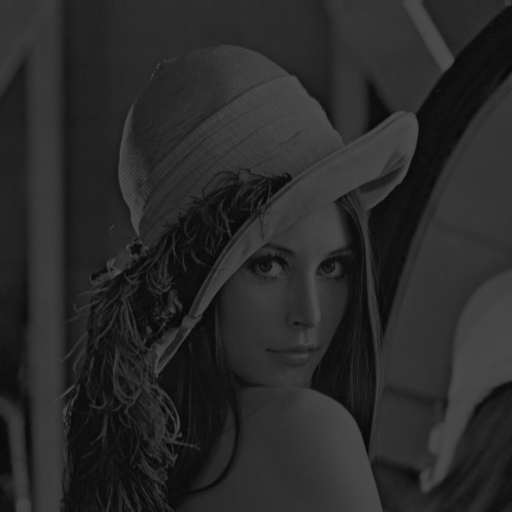

In [ ]:
divid_3_lena_gray = np.uint8(np.rint(lena_gray/3))

cv2_imshow(divid_3_lena_gray)
#cv2.imwrite('divid_3_lena_gray.bmp', divid_3_lena_gray)

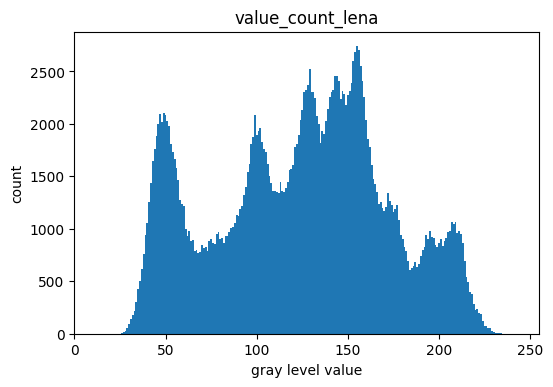

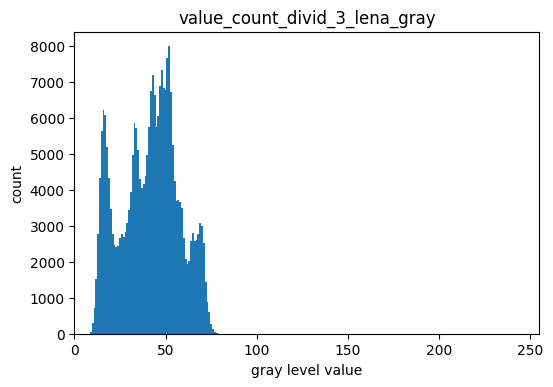

In [ ]:
# 灰階圖的色階統計

def gray_level_value_count(gray_img):
  value_count = [0]*256
  for row in gray_img:
    for pix in row:
      value_count[pix]+=1
  return value_count

def gray_level_value_count_chart(gray_img, out_fig_name):
  value_count = gray_level_value_count(gray_img)
  plt.figure(dpi=100)
  #plt.figure(dpi=500)
  plt.bar(list(range(256)),value_count,1)
  plt.title(out_fig_name[:-4])
  plt.xlabel("gray level value")
  plt.xlim(0,255)
  plt.ylabel("count")
  plt.show()
  #plt.savefig(out_fig_name)
  return

gray_level_value_count_chart(lena_gray, 'value_count_lena.png')
gray_level_value_count_chart(divid_3_lena_gray, 'value_count_divid_3_lena_gray.png')

In [ ]:
def gray_hist_equalization(gray_img):
  value_cumsum = []
  minlevel, maxlevel, sum_value = -1, -1, 0
  novalue = True
  value_count = gray_level_value_count(gray_img)
  for level, count in enumerate(value_count):
    sum_value += count
    value_cumsum.append(sum_value)
    if novalue and count>0:
      novalue=False
      minlevel = level
    if count>0:
      maxlevel = level

  new_value_count = [0]*256
  transfor_list = [0]*256
  Denominator = value_cumsum[maxlevel]-value_cumsum[minlevel]
  Numerator = lambda x: value_cumsum[x]-value_cumsum[minlevel]
  for level in range(minlevel, maxlevel+1):
    new_level = int(np.round(Numerator(level)*255/Denominator))
    transfor_list[level] = new_level
    new_value_count[new_level] += value_count[level]

  hist_equalization_lena_gray = gray_img.copy()
  for r,row in enumerate(hist_equalization_lena_gray):
    for c,_ in enumerate(row):
      hist_equalization_lena_gray[r,c] = transfor_list[hist_equalization_lena_gray[r,c]]
  return hist_equalization_lena_gray

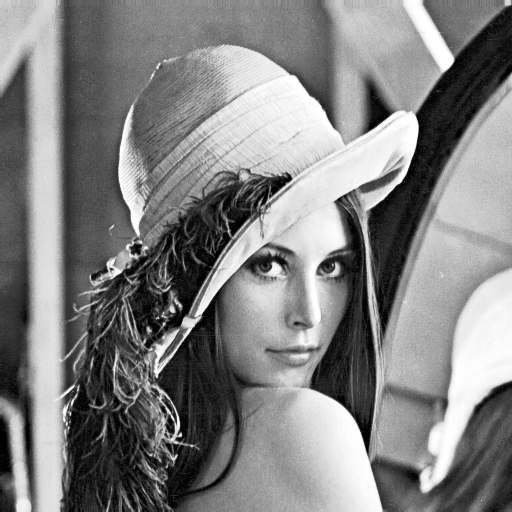

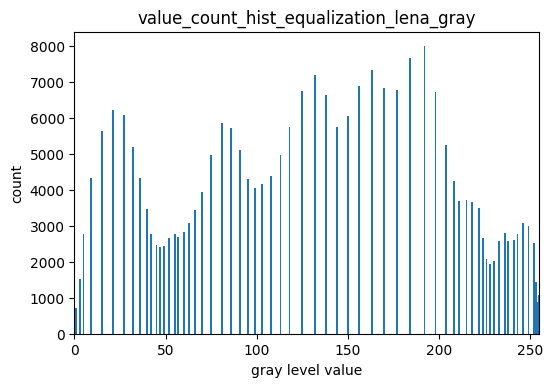

In [ ]:
hist_equalization_lena_gray = gray_hist_equalization(divid_3_lena_gray)
cv2_imshow(hist_equalization_lena_gray)
#cv2.imwrite('hist_equalization_lena_gray.bmp', hist_equalization_lena_gray)
gray_level_value_count_chart(hist_equalization_lena_gray, 'value_count_hist_equalization_lena_gray.png')

In [ ]:
J = np.array([[0,0,0],[1,1,0],[0,1,0]],dtype=bool)
K = np.array([[0,1,1],[0,0,1],[0,0,0]],dtype=bool)

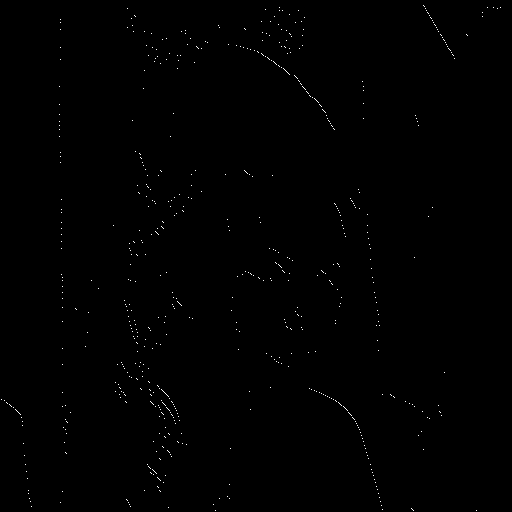

In [ ]:
JErosion = Erosion(binarize_lena, J)
KErosion = Erosion(255-binarize_lena, K)
HitandMiss_binarize_lena = ((JErosion > 128)&(KErosion > 128))*255

cv2_imshow(HitandMiss_binarize_lena)
#cv2.imwrite('HitandMiss_binarize_lena.bmp', HitandMiss_binarize_lena)

In [ ]:
octogonal_kernel = np.array([[0,1,1,1,0],
               [1,1,1,1,1],
               [1,1,1,1,1],
               [1,1,1,1,1],
               [0,1,1,1,0]],dtype=bool)

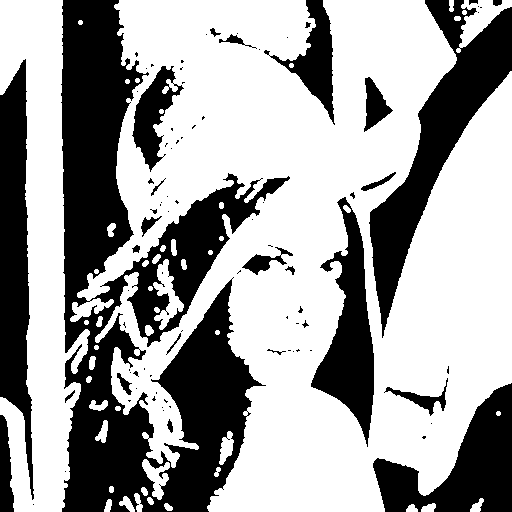

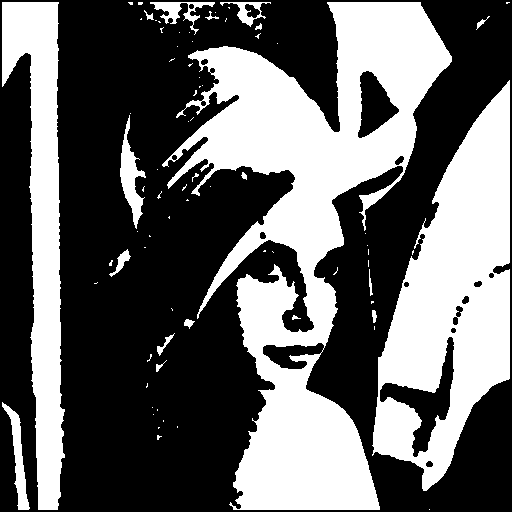

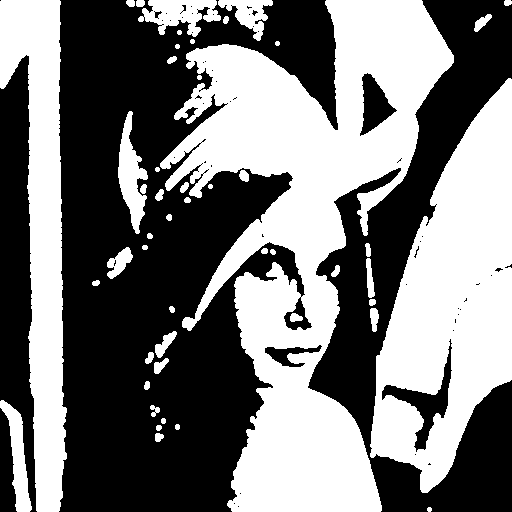

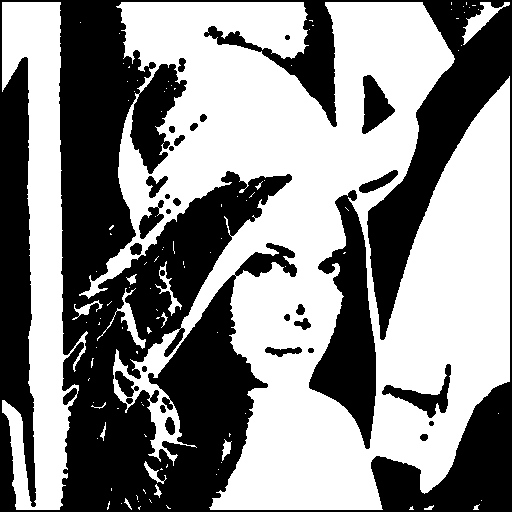

In [ ]:
Dilation_binarize_lena = Dilation(binarize_lena, octogonal_kernel)
Erosion_binarize_lena = Erosion(binarize_lena, octogonal_kernel)
Opening_binarize_lena = Dilation(Erosion_binarize_lena, octogonal_kernel)
Closing_binarize_lena = Erosion(Dilation_binarize_lena, octogonal_kernel)

cv2_imshow(Dilation_binarize_lena)
cv2_imshow(Erosion_binarize_lena)
cv2_imshow(Opening_binarize_lena)
cv2_imshow(Closing_binarize_lena)
#cv2.imwrite('Dilation_binarize_lena.bmp', Dilation_binarize_lena)
#cv2.imwrite('Erosion_binarize_lena.bmp', Erosion_binarize_lena)
#cv2.imwrite('Opening_binarize_lena.bmp', Opening_binarize_lena)
#cv2.imwrite('Closing_binarize_lena.bmp', Closing_binarize_lena)

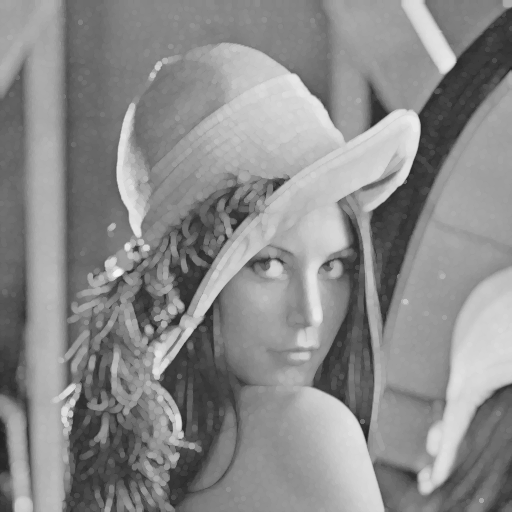

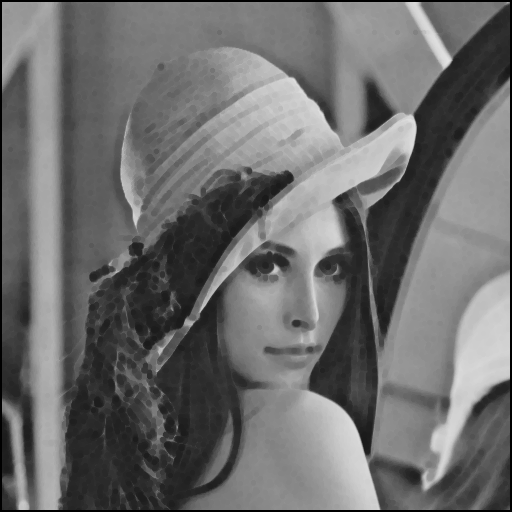

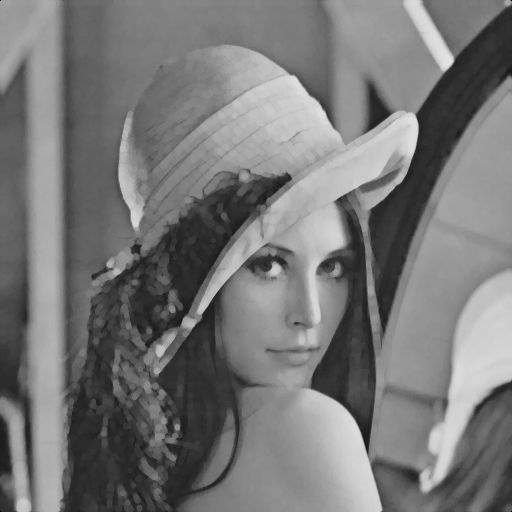

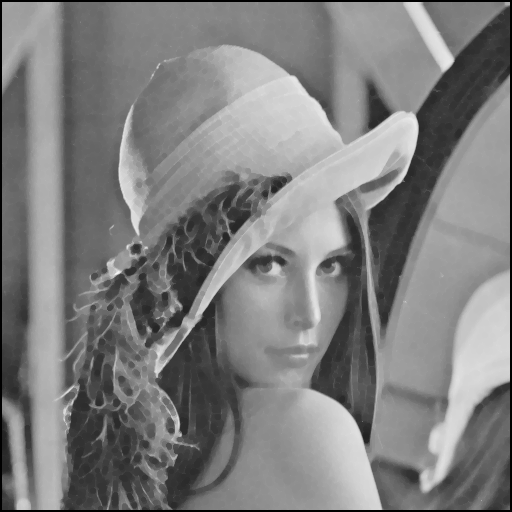

In [ ]:
Dilation_lena = Dilation(lena_gray, octogonal_kernel)
Erosion_lena = Erosion(lena_gray, octogonal_kernel)
Opening_lena = Dilation(Erosion_lena, octogonal_kernel)
Closing_lena = Erosion(Dilation_lena, octogonal_kernel)


cv2_imshow(Dilation_lena)
cv2_imshow(Erosion_lena)
cv2_imshow(Opening_lena)
cv2_imshow(Closing_lena)
#cv2.imwrite('Dilation_lena.bmp', Dilation_lena)
#cv2.imwrite('Erosion_lena.bmp', Erosion_lena)
#cv2.imwrite('Opening_lena.bmp', Opening_lena)
#cv2.imwrite('Closing_lena.bmp', Closing_lena)

In [ ]:
import cv2
import numpy as np

lena_gray = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
binarize_lena = lena_gray//128*255

binarize64_lena = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    binarize64_lena[r,c] = binarize_lena[r*8,c*8]
check_table = np.zeros((66,66))
check_table[1:-1,1:-1] = binarize64_lena

def h(b,c,d,e):
  if b != c:
    return 's'
  else:
    if d==b and e==b:
      return 'r'
    else:
      return 'q'

def f(mtx):
  mtx_list = mtx.reshape(-1)
  qvalue = 0
  rvalue = 0
  for ads in [[4,5,2,1],[4,1,0,3],[4,3,6,7],[4,7,8,5]]:
    state = h(*mtx_list[ads])
    qvalue += 1 if state=='q' else 0
    rvalue += 1 if state=='r' else 0
  if rvalue==4:
    return 5
  else:
    return qvalue


img = np.zeros((650, 650, 3), np.uint8)
img.fill(255)
result = np.zeros((64,64))
for r in range(64):
  for c in range(64):
    if check_table[r+1,c+1]>254:
      result[r,c] = f(check_table[r:r+3,c:c+3])
      if int(np.around(result[r,c]))>0:
        cv2.putText(img, str(int(np.around(result[r,c]))), (c*10+5,r*10+15), cv2.FONT_HERSHEY_DUPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

cv2.imwrite('img.bmp', img)